# Q2: Interest Rate Models and Negative Rates

Purpose of the following notebook is to replicate the results which are shown in the [blog post by John Hull](https://fincad.com/blog/interest-rate-models-and-negative-rates). In this post four models that are used to model interest rate derivatives are described:

- Black-Sholes model (with shift)
- Bachelier model
- constant elasticity of variance (CEV) model
- SABR model

Then Black-Sholes model with shift and Bachelier model are discussed to more detail. More precisely the author provides several tables with implied volatilities - one "input" for the Bachelier model and two "computed" for the Black-Sholes model with different shifts. This illustrates that the shift parameter heavily influences the implied volatility from the Black-Scholes model.

## Housekeeping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
from scipy.optimize import fsolve

In [2]:
# constants according to the blog_post
MATURITIES = [1, 3, 5, 7, 10]
CAP_RATES_0 = [np.nan, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05]
len_cap_rates = len(CAP_RATES_0)
ATM_RATES = [-0.0044, -0.0046, -0.0032, -0.0009, 0.0026]

## Initial functions definition

In [3]:
def bachelier_cap_price(F, K, T, sigma, D) -> float:
    """Calculate the cap price according to the Bachelier model.
    
    :param F: Forward rate
    :param K: Strike price
    :param T: Maturity
    :param sigma: Volatility
    :param D: Discount factor
    :return: Cap price
    """
    d = (F - K) / (sigma * np.sqrt(T))
    cap_price = D * ((F - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d))
    return cap_price

In [4]:
def black_scholes_cap_price_with_shift(F, K, T, sigma, D, s) -> float:
    """Calculate the cap price according to the Black Scholes model with shift.

    :param F: Forward rate
    :param K: Strike price
    :param T: Maturity
    :param sigma: Volatility
    :param D: Discount factor
    :param s: Shift
    :return: Cap price
    """
    F_shifted = F + s
    K_shifted = K + s
    d1 = (np.log(F_shifted / K_shifted) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    cap_price = D * (F_shifted * norm.cdf(d1) - K_shifted * norm.cdf(d2))
    return cap_price

In [5]:
def obj_func_black_scholes_shift(sigma, price, F, K, T, D, s) -> float:
    """Objective function of the Black Scholes model with shift."""
    return black_scholes_cap_price_with_shift(F, K, T, sigma, D, s) - price

def obj_func_bachelier(sigma, price, F, K, T, D) -> float:
    """Objective function of the Bachelier model."""
    return bachelier_cap_price(F, K, T, sigma, D) - price

def get_cap_rate(maturity, cap_rate_idx, cap_rates_0, atm_rates) -> float:
    """Convenience function to replicate the table in the blog post as the first row (ATM) depends on the maturity.

    :param maturity: Maturity
    :param cap_rate_idx: Row number in the table
    :param cap_rates_0: List of cap rates which we consider. First element is replaced by ATM rate.
    :param atm_rates: List of ATM rates
    :return: Cap rate
    """
    if cap_rate_idx == 0:
        return atm_rates[MATURITIES.index(maturity)]
    else:
        return cap_rates_0[cap_rate_idx]

def get_D(F, T):
    """Calculate the discount factor D for a given forward rate F and maturity T."""
    # return 1/((1+F)**T) * T
    return np.exp(-F * T) * T

def data_to_table(data):
    """Convert data to a pandas DataFrame with the column and row names according to the blof."""
    return pd.DataFrame(data=data,
                        columns=MATURITIES,
                        index=['ATM'] + [f'{cap*100}%' for cap in CAP_RATES_0[1:]])

## Results replication

### Data loading

Here we just rewrited the input data provided in the article.

In [6]:
# define the table values and to a NumPy array
implied_volatilities_bachelier_table = [
    [29.96, 43.86, 56.49, 64.79, 71.16],
    [58.6, 52.7, 61.2, 66.6, 70.9],
    [78.9, 64.2, 68, 71, 73.5],
    [98.4, 76.3, 76, 76.2, 76.7],
    [117.3, 88.3, 84.5, 82.2, 80.5],
    [153.5, 111.6, 101.9, 95.6, 89.6],
    [222.5, 155.4, 135.8, 123.5, 110.8]
]
implied_volatilities_bachelier = np.array(implied_volatilities_bachelier_table)

In [7]:
# print "input" implied volatilities for the bachelier model
data_to_table(implied_volatilities_bachelier_table)

,1,3,5,7,10
ATM,29.96,43.86,56.49,64.79,71.16
0.5%,58.60,52.70,61.20,66.60,70.90
1.0%,78.90,64.20,68.00,71.00,73.50
1.5%,98.40,76.30,76.00,76.20,76.70
2.0%,117.30,88.30,84.50,82.20,80.50
3.0%,153.50,111.60,101.90,95.60,89.60
5.0%,222.50,155.40,135.80,123.50,110.80


### Cap price calculation (Bachelier model)

For each cell in the table we calculte derivative price using pricing formula of the Bachelier model.

In [8]:
# calculate cap price according to Bachelier model for each cap rate and maturity
prices_bachelier = np.zeros((len_cap_rates, len(MATURITIES)))
for i in range(len_cap_rates):
    for j, T in enumerate(MATURITIES):
        T_index = MATURITIES.index(T)
        K = get_cap_rate(T, i, CAP_RATES_0, ATM_RATES)
        F = ATM_RATES[T_index]
        D = get_D(F, T)
        prices_bachelier[i, j] = bachelier_cap_price(F, K, T, implied_volatilities_bachelier[i, j]/1e4, D)

In [9]:
# print computed cap prices for the bachelier model
data_to_table(prices_bachelier)

,1,3,5,7,10
ATM,0.001201,0.009218,0.025603,0.048173,0.087469
0.5%,0.000135,0.002094,0.011742,0.031488,0.075956
1.0%,0.000106,0.001498,0.008222,0.023045,0.058836
1.5%,0.000091,0.001224,0.006273,0.017415,0.045929
2.0%,0.000080,0.001060,0.005085,0.013740,0.036438
3.0%,0.000067,0.000861,0.003739,0.009560,0.024481
5.0%,0.000053,0.000644,0.002483,0.005906,0.013877


### Implied volatilities calculation (Black-Scholes model)

- For each cell in the table we compute the implied volatility according to the Black-Sholes model with the drift. In other words we need to find the volatility that solves the pricing equation.
- I was not able to replicate the results pricesely, but the value are quite close to each other and changes mostly follow the same direction.
- Also we see that the implied volatilities are heavily dependent on the shift parameter.

In [10]:
def get_implied_volatilities_black_scholes(prices_bachelier, s=0.01) -> np.ndarray:
    """ Calculate implied volatilities according to Black Scholes model with shift model for each cap rate and maturity.

    :param prices_bachelier: 2D array of cap prices according to Bachelier model (corresponds to table in the blog post)
    :param s: Shift
    :return: 2D array of implied volatilities according to Black Scholes model with shift
    """
    implied_volatilities_black_scholes = np.zeros((len_cap_rates, len(MATURITIES)))

    # iterate over rows and columns of the table
    for i in range(len_cap_rates):
        for j, T in enumerate(MATURITIES):
            # collect inputs for the objective function
            T_index = MATURITIES.index(T)
            K = get_cap_rate(T, i, CAP_RATES_0, ATM_RATES)
            F = ATM_RATES[T_index]
            D = get_D(F, T)
            price = prices_bachelier[i, j]

            # solve for implied volatility using fsolve and format the result
            res = fsolve(obj_func_black_scholes_shift, np.array([0.5]), args=(price, F, K, T, D, s))[0]
            implied_volatilities_black_scholes[i, j] = round(res * 1e2, 3)
    return implied_volatilities_black_scholes

In [11]:
# print computed implied volatilities for the black_scholes model
data_to_table(get_implied_volatilities_black_scholes(prices_bachelier, s=0.02))

,1,3,5,7,10
ATM,19.235,28.776,34.459,35.148,32.914
0.5%,29.507,26.837,30.232,31.254,31.015
1.0%,36.023,29.643,30.446,30.193,29.131
1.5%,41.277,32.377,31.272,29.776,27.936
2.0%,45.657,34.776,32.280,29.825,27.230
3.0%,52.566,38.688,34.289,30.581,26.738
5.0%,62.380,44.126,37.481,32.472,27.238


In [12]:
# print computed implied volatilities for the black_scholes model
data_to_table(get_implied_volatilities_black_scholes(prices_bachelier, s=0.01))

,1,3,5,7,10
ATM,54.155,89.406,100.973,87.233,67.267
0.5%,62.414,58.470,64.113,62.993,59.081
1.0%,71.205,60.153,59.687,55.997,50.876
1.5%,77.767,62.531,58.171,52.289,46.158
2.0%,82.956,64.713,57.777,50.372,43.267
3.0%,90.654,68.250,58.145,48.975,40.322
5.0%,100.957,72.912,59.564,48.881,38.729


## Simulation

- In this part I wanted to see what is the distribution of simulated values after T time periods and how is it related to price under different model assumptions.
- On the plots below we see how shift and sigma (and price) interact with each other.
- The same price is achieved with lower variance when using higher shift.

In [13]:
def bachelier_simulation(S0, sigma, T, N, dt) -> tuple:
    """Simulate the Bachelier model.

    :param S0: Initial forward rate
    :param sigma: Volatility
    :param T: Maturity
    :param N: Number of simulations
    :param dt: Time step
    :return: Time grid and simulated forward rates
    """
    num_steps = int(T / dt) + 1
    time_grid = np.linspace(0, T, num_steps)
    dW = np.sqrt(dt) * np.random.randn(N, num_steps - 1)
    S = np.zeros((N, num_steps))
    S[:, 0] = S0

    for t in range(1, num_steps):
        S[:, t] = S[:, t - 1] + sigma * dW[:, t - 1]

    return time_grid, S

In [14]:
def black_scholes_shifted_simulation(S0, sigma, shift, T, N, dt) -> tuple:
    """Simulate the Black-Scholes model with a shift.

    :param S0: Initial stock price
    :param sigma: Volatility
    :param shift: Shift parameter
    :param T: Maturity
    :param N: Number of simulations
    :param dt: Time step
    :return: Time grid and simulated stock prices
    """
    num_steps = int(T / dt) + 1
    time_grid = np.linspace(0, T, num_steps)
    dW = np.sqrt(dt) * np.random.randn(N, num_steps - 1)
    S = np.zeros((N, num_steps))
    S[:, 0] = S0

    for t in range(1, num_steps):
        S[:, t] = (S[:, t - 1] + shift) * np.exp(-0.5 * sigma**2 * dt + sigma * dW[:, t - 1]) - shift

    return time_grid, S

In [15]:
def simulate_and_plot(implied_vol, model='bachelier', T=5, cap_rate_idx=2, n_sim=1000, dt=1/252, s=None) -> None:
    """Simulate and plot the forward rate according to the Bachelier or Black-Scholes model with shift.
    
    :param implied_vol: 2D array of implied volatilities 
    :param model: Model to use (bachelier or black_scholes) 
    :param T: Maturity
    :param cap_rate_idx: Row number in the table from the blog post
    :param n_sim: Number of simulations 
    :param dt: Time step 
    :param s: Shift parameter for the Black-Scholes model (None for Bachelier model) 
    :return: None 
    """

    T_index = MATURITIES.index(T)
    K = get_cap_rate(T, cap_rate_idx, CAP_RATES_0, ATM_RATES)
    F0 = ATM_RATES[T_index]

    if model == 'bachelier':
        sigma_denominator = 1e4
    elif model == 'black_scholes':
        sigma_denominator = 1e2
        if s is None:
            raise ValueError('Shift s must be specified for the Black Scholes model')
    else:
        raise ValueError('Model must be either bachelier or black_scholes')

    sigma = implied_vol[cap_rate_idx, T_index] / sigma_denominator

    # Generate simulations
    if model == 'bachelier':
        time_grid, sims = bachelier_simulation(F0, sigma, T, n_sim, dt)
        plot_label = f'Bachelier Model Simulation \n F0={F0*100}%, sigma={sigma*sigma_denominator:.3f} b.p., strike={K*100}%, T={T}'
    elif model == 'black_scholes':
        time_grid, sims = black_scholes_shifted_simulation(F0, sigma, s, T, n_sim, dt)
        plot_label = f'Black-Scholes Model Simulation \n shift={s}, F0={F0*100}%, sigma={sigma*sigma_denominator:.3f}%, strike={K*100}%, T={T}'

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(12, 6), sharey=True)
    plt.suptitle(plot_label, fontsize=16)

    # Plot simulations
    for i in range(n_sim):
        ax1.plot(time_grid, sims[i], color='blue', alpha=0.05)
    ax1.set_title('Bachelier Model Simulations')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Forward Rate')
    ax1.grid(True)
    # horizontal line at strike price
    ax1.axhline(y=K, color='r', linestyle='--', label='Strike Price')
    ax1.legend()

    # Plot empirical density at time T using sns kdeplot on ax2
    sns.kdeplot(data=pd.DataFrame(sims[:, -1], columns=['y']), y='y', ax=ax2, fill=True)  #, vertical=True)
    ax2.set_title(f'Empirical Density at T={T}')
    ax2.grid(True)
    ax2.axhline(y=K, color='r', linestyle='--', label='Strike Price')

    plt.tight_layout()
    plt.show()
    
    return None

### Bachelier model

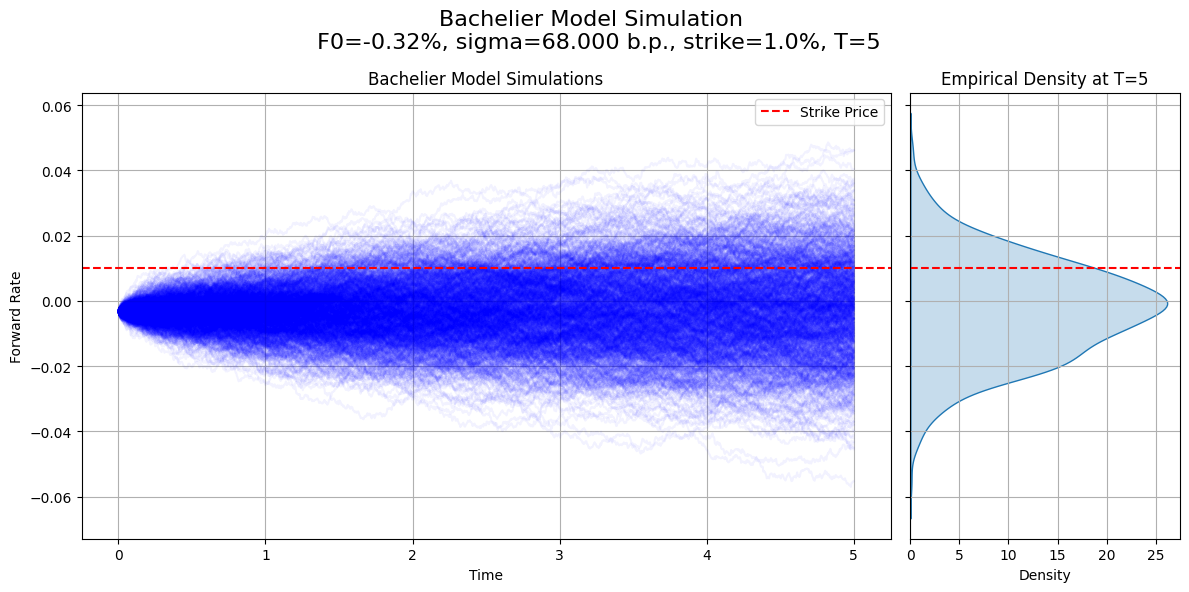

In [16]:
simulate_and_plot(implied_vol=implied_volatilities_bachelier, model='bachelier')

### Black-Scholes model

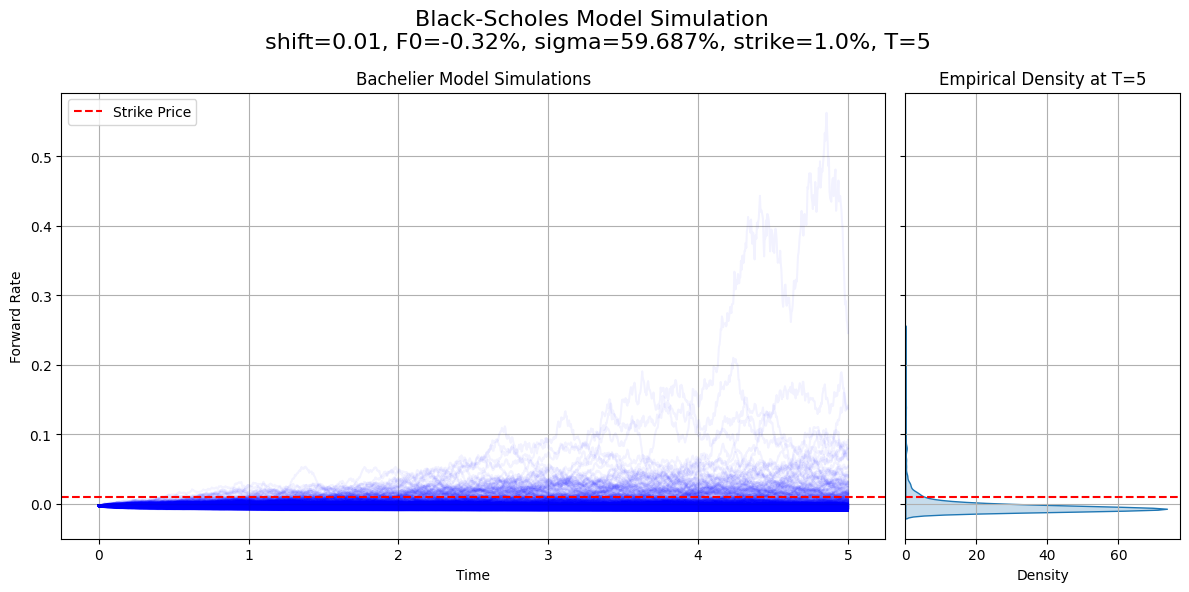

In [17]:
s = 0.01
simulate_and_plot(implied_vol=get_implied_volatilities_black_scholes(prices_bachelier, s=s), model='black_scholes', s=s)

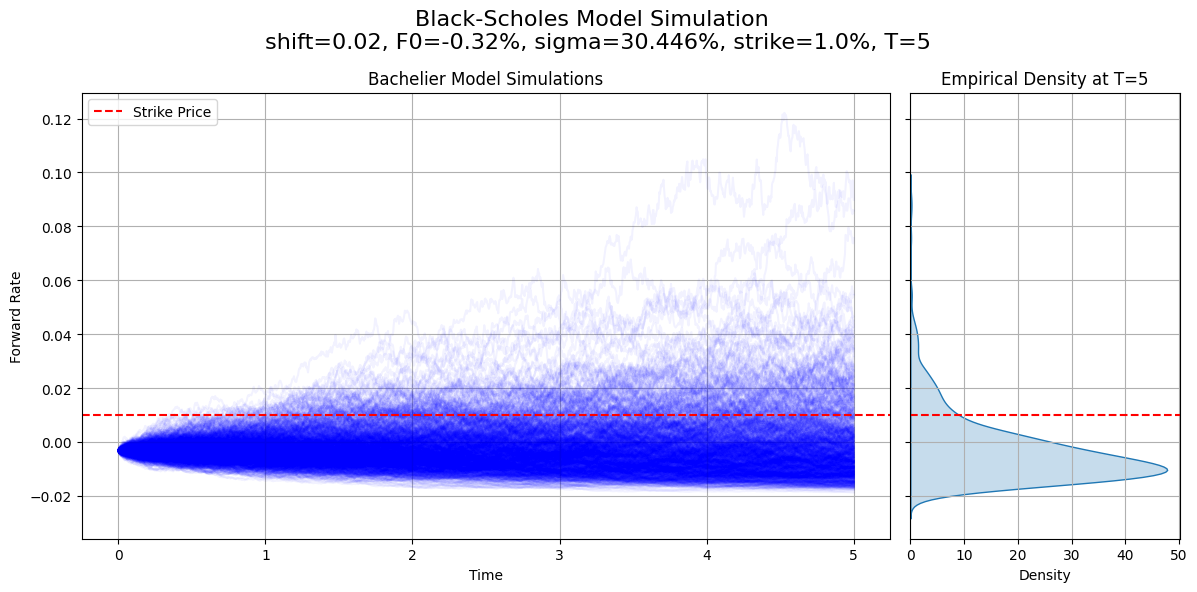

In [18]:
s = 0.02
simulate_and_plot(implied_vol=get_implied_volatilities_black_scholes(prices_bachelier, s=s), model='black_scholes', s=s)

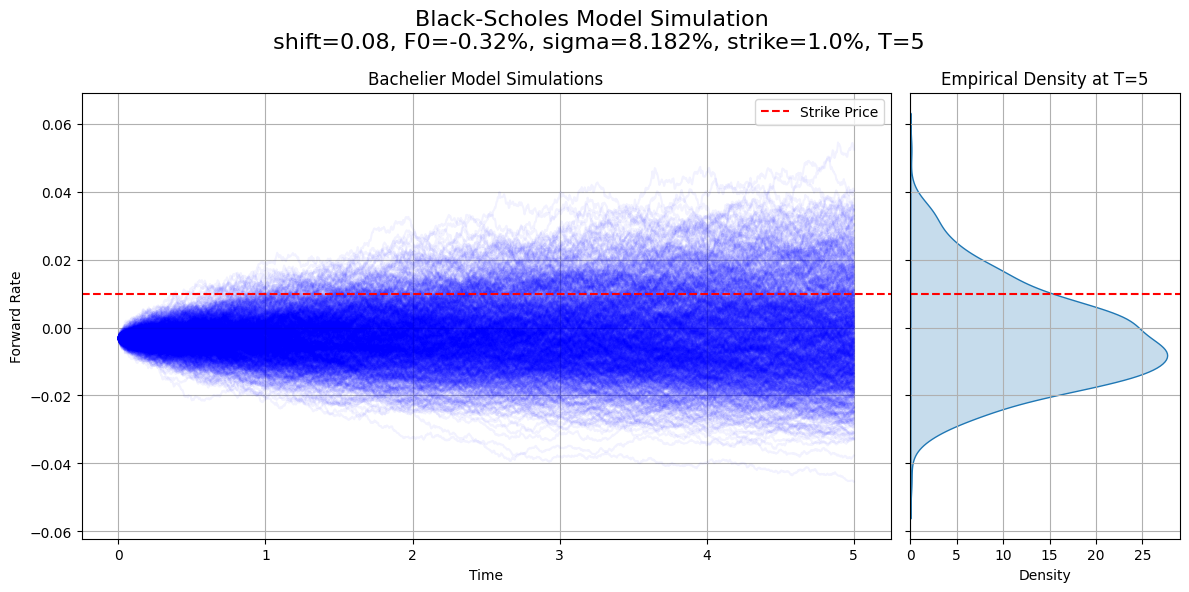

In [19]:
s = 0.08
simulate_and_plot(implied_vol=get_implied_volatilities_black_scholes(prices_bachelier, s=s), model='black_scholes', s=s)

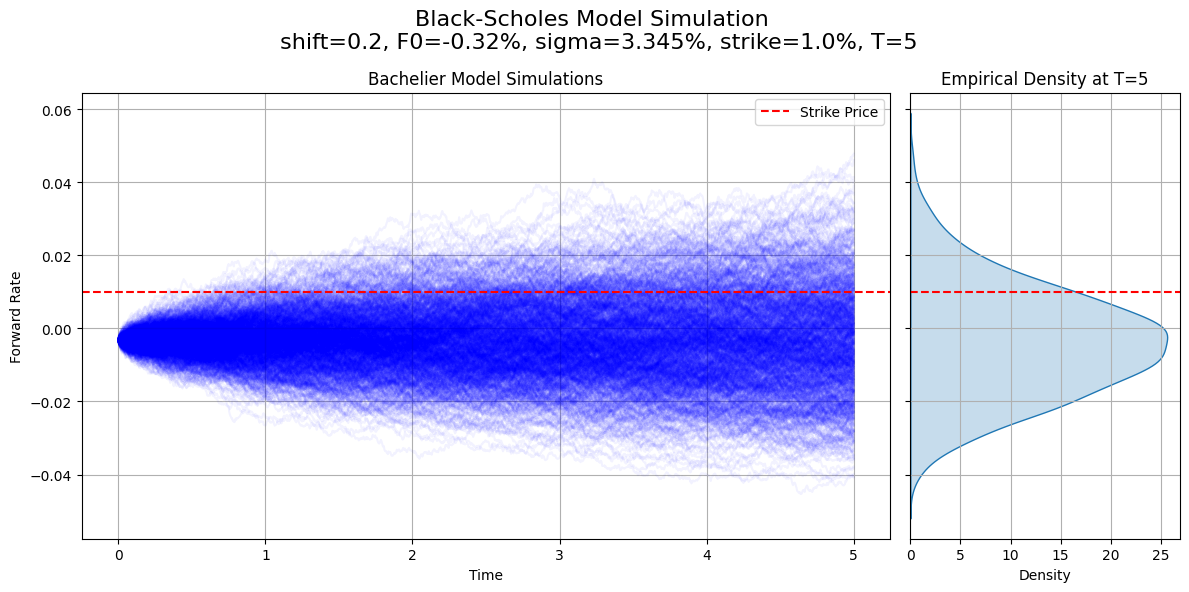

In [20]:
s = 0.2
simulate_and_plot(implied_vol=get_implied_volatilities_black_scholes(prices_bachelier, s=s), model='black_scholes', s=s)